In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
from mpmath import mp
import math
import csv

# Load Data
Load real data and determine profile sizes for genes and taxon; Also because boxcox transformation will be applied, filter out lines where gene/taxon size is zero OR score is zero.

In [6]:
original_data = pd.read_csv('../../data/real_data_experiment/experiment/results/E_bp_sym_pic_resnik_Results.tsv',\
                           sep='\t', header=0, low_memory=True, memory_map=True)
gene_taxon_scores = original_data.copy()

#keep only columns of interest for current code
# gene_taxon_scores.drop(columns=['Query Profile', 'Query Name', 'Corpus Profile',
#                                 'Corpus Profile Name', 'URI'], inplace=True)
# gene_taxon_scores.rename(columns={'Query Profile Size':'taxon'}, inplace=True)
# gene_taxon_scores.rename(columns={'Corpus Profile Size':'gene'}, inplace=True)
# gene_taxon_scores.rename(columns={'Overall Similarity':'scores'}, inplace=True)

Obtain the profile sizes for genes and phenotypes. Then persist values to file.

In [7]:
phenotype_pr_sizes = []
gene_pr_sizes = []
phenotype_pr_sizes_dict = dict()
gene_pr_sizes_dict = dict()
taxon_data = pd.read_csv('../../data/real_data_experiment/input_files/Swartz_phenotypic_profiles.txt',\
                           sep='\t', header=0)
genes_data = pd.read_csv('../../data/real_data_experiment/input_files/Annotations_KBGenes2016.txt',\
                    sep='\t', header=None, names=['geneID', 'uberon_val', 'pato_val'])
genes.dropna(axis=0, inplace=True, subset=['uberon_val'])

for i in original_data.index:
    taxon = original_data.at[i, 'Character Number']
    gene = original_data.at[i, 'GeneID']
#     print(taxon)    
    if taxon not in phenotype_pr_sizes_dict:
        taxon_size = taxon_data[taxon_data['Character']==taxon].Character.count()
        phenotype_pr_sizes_dict[taxon] = taxon_size
    else:
        taxon_size = phenotype_pr_sizes_dict[taxon]
    if gene not in gene_pr_sizes_dict:
        gene_size = genes_data[genes_data['geneID']==gene].geneID.count()
        gene_pr_sizes_dict[gene] = gene_size
    else:
        gene_size = gene_pr_sizes_dict[gene]    
#     print(taxon_size)
    phenotype_pr_sizes.append(taxon_size)
    gene_pr_sizes.append(gene_size)
    
original_data['taxon_size'] = phenotype_pr_sizes
original_data['gene_size'] = gene_pr_sizes
original_data.to_csv("../../data/real_data_experiment/experiment/results/scores_sizes.tsv", index=False, 
              sep="\t")

Eliminate all the genes that have profile size zero or score zero.
This is needed in order to apply later on box cox transformation, which accepts only positive, non zero inputs.

In [21]:
input = pd.read_csv('../../data/real_data_experiment/experiment/results/scores_sizes.tsv',
                   header=0, sep='\t')

input_filtered = input[input.gene_size != 0]
input_filtered = input_filtered[input_filtered['Median nIC'] != 0]
input_filtered.to_csv("../../data/real_data_experiment/experiment/results/scores_sizes_filtered.tsv", index=False, 
              sep="\t")

# Generate average similarity scores

We will compute the average score for each pair (gene_size, taxon_size), in order to manipulate data easily and have clearer view of how the data looks, since multiple pairs genes and taxons with same profile sizes can have same similarity scores.

In [27]:
def generate_avg_scores(input_filtered):

    if len(input_filtered) == 0:
        print('missing values for scores/taxon profile sizes/gene profile sizes')
        return

    input_filtered = input_filtered.groupby(['taxon_size','gene_size'], as_index=False)['Median nIC'].mean() 
    input_filtered.rename(columns={'Median nIC':'avg_scores'}, inplace=True)    
    return input_filtered

In [28]:
gene_taxon_avg_scores = generate_avg_scores(input_filtered)
print(len(gene_taxon_avg_scores))
print(gene_taxon_avg_scores.head())

3966
   taxon_size  gene_size  avg_scores
0           3          1    0.037964
1           3          2    0.034825
2           3          3    0.038560
3           3          4    0.049434
4           3          5    0.057835


In [29]:
print(input_filtered.head())

   Character Number                                             GeneID  \
0                 1  http://www.informatics.jax.org/marker/MGI:1924366   
1                 1  http://www.informatics.jax.org/marker/MGI:1923407   
2                 1  http://www.informatics.jax.org/marker/MGI:2673855   
4                 1  http://www.informatics.jax.org/marker/MGI:1921765   
5                 1               http://zfin.org/ZDB-GENE-030131-6701   

   Genename  Median nIC  Evidence  taxon_size  gene_size  
0     mtmr2       0.020       NaN          11         26  
1   slc35d3       0.015       NaN          11          4  
2  gltscr1l       0.015       NaN          11          6  
4    cdkal1       0.040       NaN          11         52  
5     nfkb2       0.020       NaN          11         35  


# Data Transformation

Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. 

## Log and BoxCox Transformation

Gene Logarithm, Taxon Logarithm, Average scores Logarithm
Gene BoxCox, Taxon BoxCox, Average scores BoxCox

In [13]:
geneLog = gene_taxon_avg_scores['gene_size'].apply(np.log)
taxonLog = gene_taxon_avg_scores['taxon_size'].apply(np.log)
avg_scoresLog = gene_taxon_avg_scores['avg_scores'].apply(np.log)

geneBoxCox, lmbda1 = ss.boxcox(gene_taxon_avg_scores['gene_size'])
taxonBoxCox, lmbda2 = ss.boxcox(gene_taxon_avg_scores['taxon_size'])
avg_scoresBoxCox, lmbda3 = ss.boxcox(gene_taxon_avg_scores['avg_scores'])

data = pd.DataFrame(
    {
        'gene': gene_taxon_avg_scores['gene_size'],
        'taxon': gene_taxon_avg_scores['taxon_size'],        
        'geneLog': geneLog,
        'taxonLog': taxonLog,
        'avg_scoresLog': avg_scoresLog,
        'z_values_log': '',
        'p_values_log': '',
        'geneBoxCox': geneBoxCox,
        'taxonBoxCox': taxonBoxCox,
        'avg_scoresBoxCox': avg_scoresBoxCox,
        'z_values_boxcox': '',
        'p_values_boxcox': ''
    })
data.set_index(['geneLog', 'taxonLog'])
print(data.head())

   gene  taxon   geneLog  taxonLog  avg_scoresLog z_values_log p_values_log  \
0     1      3  0.000000  1.098612      -3.271106                             
1     2      3  0.693147  1.098612      -3.357424                             
2     3      3  1.098612  1.098612      -3.255544                             
3     4      3  1.386294  1.098612      -3.007123                             
4     5      3  1.609438  1.098612      -2.850169                             

   geneBoxCox  taxonBoxCox  avg_scoresBoxCox z_values_boxcox p_values_boxcox  
0    0.000000     2.818616         -1.809065                                  
1    0.776417     2.818616         -1.831500                                  
2    1.317546     2.818616         -1.804936                                  
3    1.746569     2.818616         -1.735357                                  
4    2.107761     2.818616         -1.687632                                  


In [14]:
def compute_std_dev(forLog):
    
    std_dev = 0
    if forLog == True:
        mean = avg_scoresLog.mean()
        avg_scores = avg_scoresLog
    else:
        mean = avg_scoresBoxCox.mean()
        avg_scores = avg_scoresBoxCox
    for score in avg_scores:
        input = score-mean
        std_dev = std_dev + math.pow(input, 2)
    
    std_dev = std_dev/len(avg_scores)
    std_dev = math.sqrt(std_dev)
    return std_dev    

In [16]:
def compute_z_values(forLog, const, coeff_taxon, coeff_gene,std_dev):
            
    z_values = []
    if forLog == True:
        length = len(avg_scoresLog)
        avg_scores = 'avg_scoresLog'
        taxon_type = 'taxonLog'
        gene_type = 'geneLog'
        z_value_type = 'z_values_log'
    else:
        length = len(avg_scoresBoxCox)
        avg_scores = 'avg_scoresBoxCox'
        taxon_type = 'taxonBoxCox'
        gene_type = 'geneBoxCox'
        z_value_type = 'z_values_boxcox'
    for i in range(length):
        observed_value = data.at[i, avg_scores]
        predicted_value = const+coeff_taxon*data.at[i, taxon_type]+\
                            coeff_gene*data.at[i, gene_type]        
        z_value = (observed_value - predicted_value)/std_dev
        z_values.append(z_value)
        data.at[i, z_value_type] = z_value      
        
    return z_values

These are the equation's coefficients obtained when we used OLS and WLS multiple linear regressions.

In [15]:
const_boxcox = -1.938113
coeff_taxonBoxCox = -0.000546
coeff_geneBoxCox = 0.022443

const_log = -4.233184
coeff_taxonLog = -0.118803
coeff_geneLog = 0.328559

We will compute p values for all the average scores. In order to do that, we will have to compute first the Z values for all avg scores.

## Computing Z values

In [18]:
std_deviation_log = compute_std_dev(True)
std_deviation_boxcox = compute_std_dev(False)
z_values_log = compute_z_values(True, const_log, coeff_taxonLog, coeff_geneLog,\
                            std_deviation_log)
z_values_boxcox = compute_z_values(False, const_boxcox, coeff_taxonBoxCox, coeff_geneBoxCox,\
                            std_deviation_boxcox)
for i in range(5):
    print(z_values_log[i]) 

2.855698541150872
2.0348503426449893
1.952941345362626
2.355187490128834
2.5737917955131158


## Computing p values

In [19]:
p_valuesLog = []
p_valuesBoxCox = []
for i in range(len(z_values_log)):    
    no1 = -math.e **(-data.at[i,'z_values_log']*math.pi/math.sqrt(6)-mp.euler)
    no2 = -math.e **(-data.at[i,'z_values_boxcox']*math.pi/math.sqrt(6)-mp.euler)
    p_value1 = 1 - math.exp(no1)
    p_value2 = 1 - math.exp(no2)
    p_valuesLog.append(p_value1)
    p_valuesBoxCox.append(p_value2)
    data.at[i,'p_values_log'] = p_value1
    data.at[i,'p_values_boxcox'] = p_value2    
for i in range(5):
    print(p_valuesBoxCox[i]) 

0.16978619032727127
0.22946258082418114
0.20605390060425477
0.12974771763399362
0.09462489146602959


Let's merge our results with the original data.

In [31]:
merged_data = input_filtered.merge(data, left_on=['taxon_size', 'gene_size'],
                           right_on=['taxon', 'gene'], how='left')
merged_data.drop(columns=['gene', 'taxon', 'avg_scoresLog', 'geneLog',\
                          'taxonLog', 'avg_scoresBoxCox', 'geneBoxCox',\
                          'taxonBoxCox'], inplace=True)

## Compute expected values

In [33]:
no_unique_taxon = merged_data['Character Number'].nunique()
merged_data['e_values_log'] = [no_unique_taxon*p_value for p_value
                             in merged_data['p_values_log']]
merged_data['e_values_boxcox'] = [no_unique_taxon*p_value for p_value
                             in merged_data['p_values_boxcox']]

In [34]:
merged_data.to_csv('../../data/real_data_experiment/experiment/results/P_Z_Expect_values.tsv', index=False, 
              sep="\t", float_format='%.17f')

In [30]:
plot_data = pd.read_csv('../../data/real_data_experiment/experiment/results/P_Z_Expect_values.tsv',\
                           sep='\t', header=0, low_memory=True, memory_map=True)

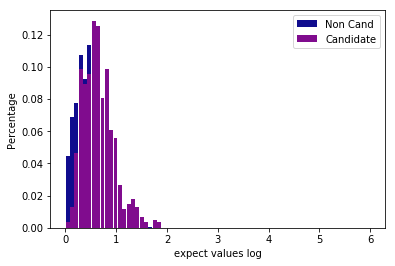

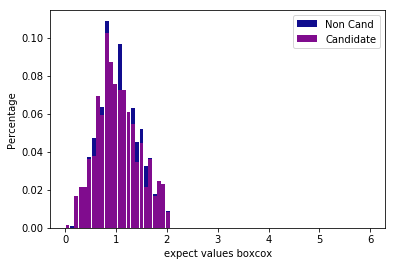

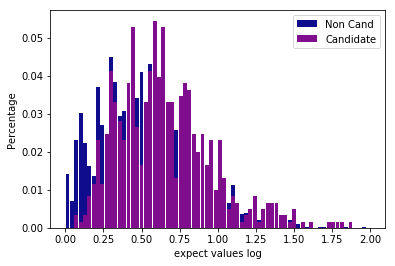

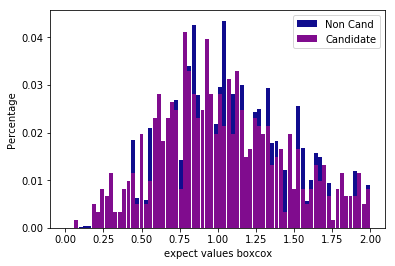

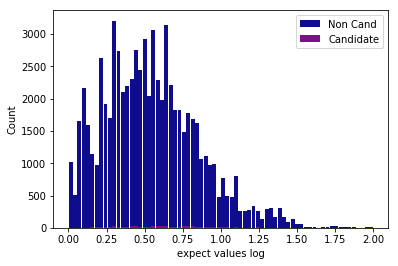

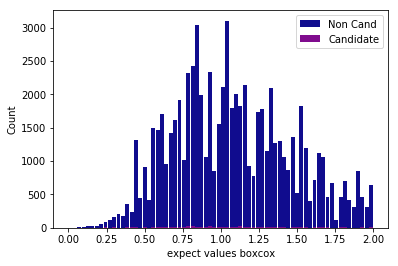

In [77]:
#get lines where evidence is a number
plot_dataEvidenceNan = plot_data[plot_data.Evidence.isnull()]
plot_dataEvidenceValid = plot_data[plot_data.Evidence.notnull()]
evidenceNanLog = plot_dataEvidenceNan.e_values_log
evidenceValidLog = plot_dataEvidenceValid.e_values_log
ran = np.linspace(0, 6)
plt.hist(evidenceNanLog, range=(0,6), bins=70, rwidth=0.9, color='#100c8e', 
         weights=np.ones(len(evidenceNanLog)) / len(evidenceNanLog), label='Non Cand')
plt.hist(evidenceValidLog, range=(0,6), bins=70, rwidth=0.9, color='#800c8e',
        weights=np.ones(len(evidenceValidLog)) / len(evidenceValidLog), label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values log')
plt.ylabel('Percentage')
plt.show()

evidenceNanBoxCox = plot_dataEvidenceNan.e_values_boxcox
evidenceValidBoxCox = plot_dataEvidenceValid.e_values_boxcox
ran = np.linspace(0, 6)
plt.hist(evidenceNanBoxCox, range=(0,6), bins=70, rwidth=0.9, color='#100c8e', 
         weights=np.ones(len(evidenceNanBoxCox)) / len(evidenceNanBoxCox), label='Non Cand')
plt.hist(evidenceValidBoxCox, range=(0,6), bins=70, rwidth=0.9, color='#800c8e',
        weights=np.ones(len(evidenceValidBoxCox)) / len(evidenceValidBoxCox), label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values boxcox')
plt.ylabel('Percentage')
plt.show()

plot_data = plot_data[plot_data['e_values_log'] < 2]
plot_dataEvidenceNan = plot_data[plot_data.Evidence.isnull()]
plot_dataEvidenceValid = plot_data[plot_data.Evidence.notnull()]
evidenceNanLog = plot_dataEvidenceNan.e_values_log
evidenceValidLog = plot_dataEvidenceValid.e_values_log
ran = np.linspace(0, 6)
plt.hist(evidenceNanLog, range=(0,2), bins=70, rwidth=0.9, color='#100c8e', 
         weights=np.ones(len(evidenceNanLog)) / len(evidenceNanLog), label='Non Cand')
plt.hist(evidenceValidLog, range=(0,2), bins=70, rwidth=0.9, color='#800c8e',
        weights=np.ones(len(evidenceValidLog)) / len(evidenceValidLog), label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values log')
plt.ylabel('Percentage')
plt.show()

plot_data = plot_data[plot_data['e_values_boxcox'] < 2]
evidenceNanBoxCox = plot_dataEvidenceNan.e_values_boxcox
evidenceValidBoxCox = plot_dataEvidenceValid.e_values_boxcox
ran = np.linspace(0, 6)
plt.hist(evidenceNanBoxCox, range=(0,2), bins=70, rwidth=0.9, color='#100c8e', 
         weights=np.ones(len(evidenceNanBoxCox)) / len(evidenceNanBoxCox), label='Non Cand')
plt.hist(evidenceValidBoxCox, range=(0,2), bins=70, rwidth=0.9, color='#800c8e',
        weights=np.ones(len(evidenceValidBoxCox)) / len(evidenceValidBoxCox), label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values boxcox')
plt.ylabel('Percentage')
plt.show()

plot_data = plot_data[plot_data['e_values_log'] < 2]
plot_dataEvidenceNan = plot_data[plot_data.Evidence.isnull()]
plot_dataEvidenceValid = plot_data[plot_data.Evidence.notnull()]
evidenceNanLog = plot_dataEvidenceNan.e_values_log
evidenceValidLog = plot_dataEvidenceValid.e_values_log
ran = np.linspace(0, 6)
plt.hist(evidenceNanLog, range=(0,2), bins=70, rwidth=0.9, color='#100c8e', label='Non Cand')
plt.hist(evidenceValidLog, range=(0,2), bins=70, rwidth=0.9, color='#800c8e', label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values log')
plt.ylabel('Count')
plt.show()

plot_data = plot_data[plot_data['e_values_boxcox'] < 2]
evidenceNanBoxCox = plot_dataEvidenceNan.e_values_boxcox
evidenceValidBoxCox = plot_dataEvidenceValid.e_values_boxcox
ran = np.linspace(0, 6)
plt.hist(evidenceNanBoxCox, range=(0,2), bins=70, rwidth=0.9, color='#100c8e', label='Non Cand')
plt.hist(evidenceValidBoxCox, range=(0,2), bins=70, rwidth=0.9, color='#800c8e', label='Candidate')
plt.legend(loc='upper right')
plt.xlabel('expect values boxcox')
plt.ylabel('Count')
plt.show()